In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import os
from FACS_Sampling.utils import create_adata

sc.set_figure_params(figsize=(8,8), fontsize=15, )

In [5]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
import warnings
warnings.filterwarnings("ignore")

/home/ekarimi/miniconda3/envs/facs_sampling/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.6 anndata==0.10.3 umap==0.5.5 numpy==1.26.0 scipy==1.11.4 pandas==2.1.1 scikit-learn==1.3.2 statsmodels==0.14.0 igraph==0.11.3 pynndescent==0.5.11


In [2]:

# Get the file path from the environment variable
file_path_env = os.getenv('MY_FACS_DATA_PATH')
input_file1 = os.path.join(file_path_env,'sara_data',"adata_ref_sara_2M.h5ad")
input_file2 = os.path.join(file_path_env,'sara_data', 'reps',"random_adata_2_30__0.h5ad")
input_file3 = os.path.join(file_path_env,'sara_data', 'reps',"fsbs_adata_2_30__0.h5ad")

adata_ref = sc.read_h5ad(input_file1)
adata_random = sc.read_h5ad(input_file2)
adata_fsbs =  sc.read_h5ad(input_file3)


In [3]:
label_key = 'population'

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_standardized = scaler.fit_transform(adata_ref.X)
X = data_standardized
adata_ref.X = data_standardized

In [5]:
import time

# Your code here



In [6]:
from scipy.linalg import clarkson_woodruff_transform

In [7]:
from sklearn.decomposition import PCA

In [8]:
start_time = time.time()
pca = PCA(n_components=22)

# Fit PCA on your data
pca.fit(X)

# Transform the data to the PCA space
X_pca = pca.transform(X)

elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 3.4755375385284424 seconds


In [9]:
ad_ref = adata_ref.copy()
ad_ref.X = X_pca

In [10]:
# Generate another batch of data for fsbs
from FACS_Sampling.methods.methods import bin_sample
start_time = time.time()

seed = 123
np.random.seed(seed)
new_seed = np.random.randint(100000)
# %time
ps, _ = bin_sample(ad_ref, n_bins=20, s_size=500, seed=new_seed)
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 87.31982326507568 seconds


In [11]:
ps.shape[0]

143809

### Random on pca data

In [12]:
# Generate another batch of data for fsbs
from FACS_Sampling.methods.methods import sample_random
start_time = time.time()

seed = 123
np.random.seed(seed)
new_seed = np.random.randint(100000)
rs = sample_random(ad_ref, s_size=ps.shape[0], seed=new_seed)
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 0.10548567771911621 seconds


### Clarkson sketching on pca (scipy)

In [ ]:
# Generate another batch of data for fsbs
start_time = time.time()

seed = 123
np.random.seed(seed)
new_seed = np.random.randint(100000)
clarkson_woodruff_transform(
rs = sample_random(ad_ref, s_size=ps.shape[0], seed=new_seed)
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time} seconds")

In [18]:
start_time = time.time()

out = clarkson_woodruff_transform(adata_random.X, 100000)

elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 0.02703690528869629 seconds


In [21]:
out.shape

(100000, 22)

### Geometric sketching

In [22]:
start_time = time.time()

# Compute PCs.
from fbpca import pca
U, s, Vt = pca(X, k=22) # E.g., 22 PCs.
X_dimred = U[:, :22] * s[:22]
# Now, you are ready to sketch!

# Sketch.
from geosketch import gs
N = ps.shape[0] # Number of samples to obtain from the data set.
sketch_index = gs(X_dimred, N, replace=False)

X_sketch = X_dimred[sketch_index]
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 602.7462697029114 seconds


In [23]:
new_fsbs = adata_ref[ps].copy()
new_random = adata_ref[rs].copy()

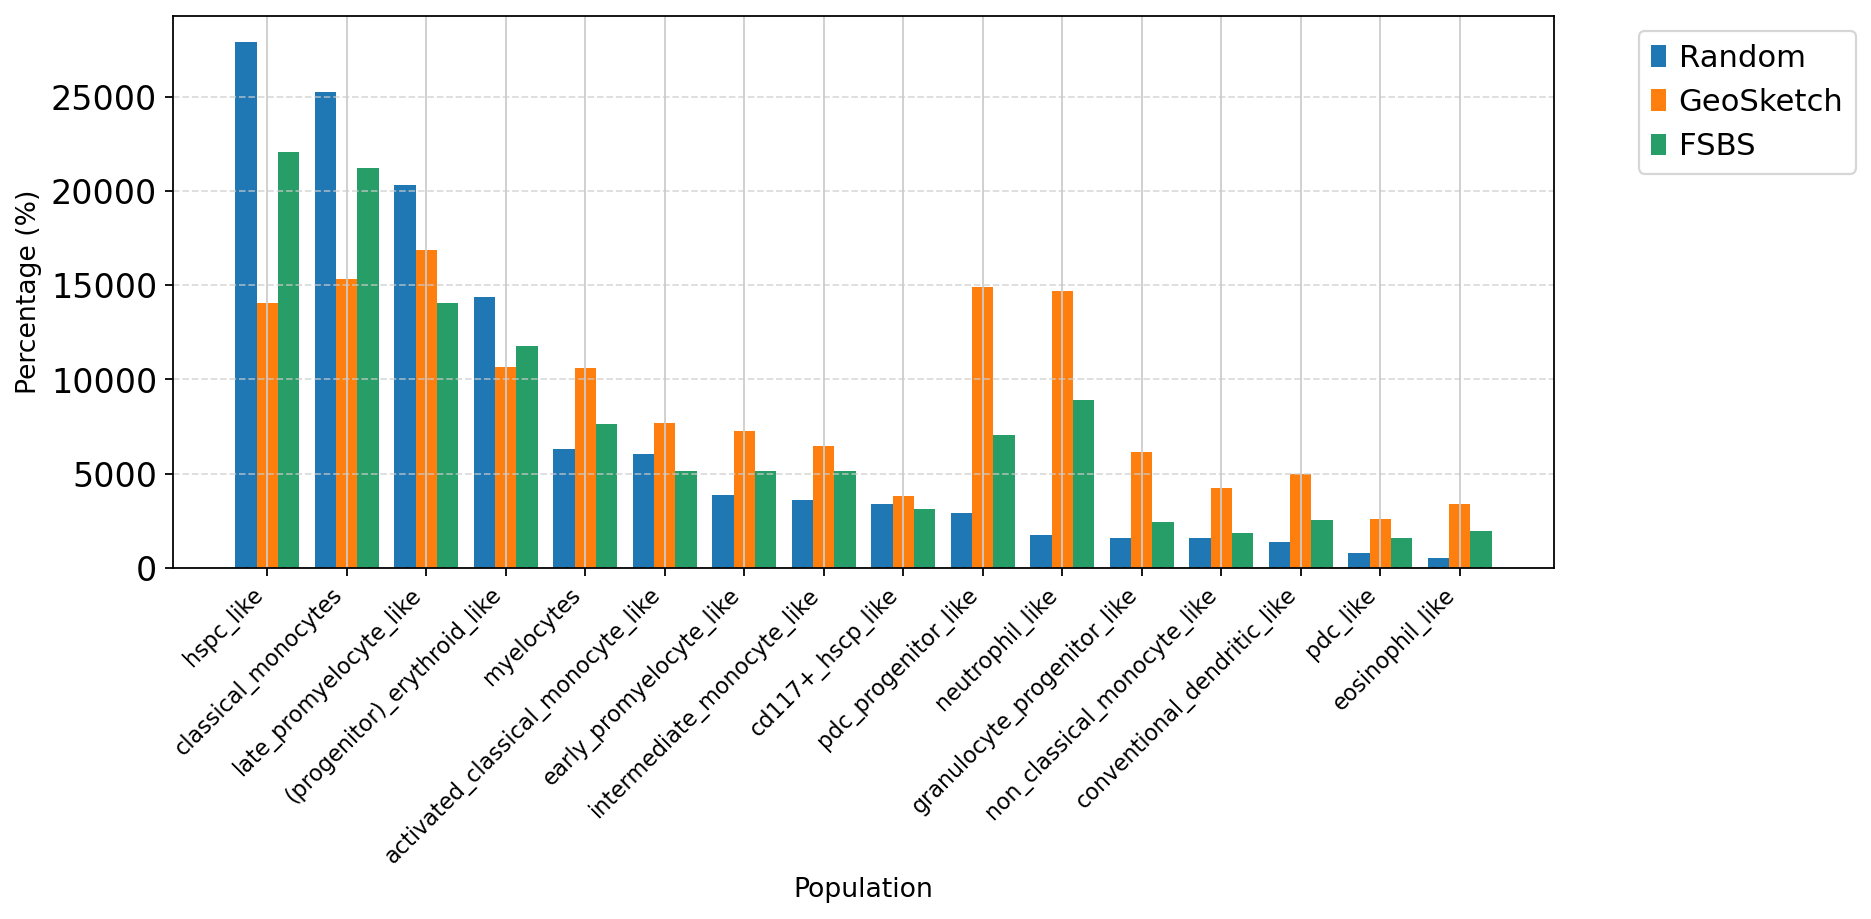

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scanpy as sc

def plot_improved_population_distribution(adata_list, labels, adata_ref):
    # Create a DataFrame to hold the count data
    pop_counts = pd.DataFrame({
        label: adata.obs['population'].value_counts(normalize=False)# * 100
        for adata, label in zip(adata_list, labels)
    })

    # Sort the populations based on the counts in adata_ref
    ref_order = adata_ref.obs['population'].value_counts().index
    pop_counts = pop_counts.reindex(ref_order)

    # Create the bar plot
    fig, ax = plt.subplots(figsize=(12, 6))
    n = len(pop_counts.columns)
    bar_width = 0.8 / n
    indices = np.arange(len(pop_counts))

    for i, label in enumerate(labels):
        ax.bar(indices + i * bar_width, pop_counts[label], bar_width, label=label)

    # Improve the aesthetics
    ax.set_xlabel('Population', fontsize=12)
    ax.set_ylabel('Percentage (%)', fontsize=12)
    ax.set_xticks(indices + bar_width * (n - 1) / 2)
    ax.set_xticklabels(pop_counts.index, rotation=45, ha='right', fontsize=10)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Example usage
plot_improved_population_distribution([adata_random, adata_ref[sketch_index].copy(), adata_fsbs],
                                      ['Random', 'GeoSketch', 'FSBS'], adata_ref)


In [24]:

plot_improved_population_distribution([adata_ref[sketch_index].copy(), adata_fsbs],
                                      ['GeoSketch', 'FSBS'], adata_ref)

NameError: name 'plot_improved_population_distribution' is not defined

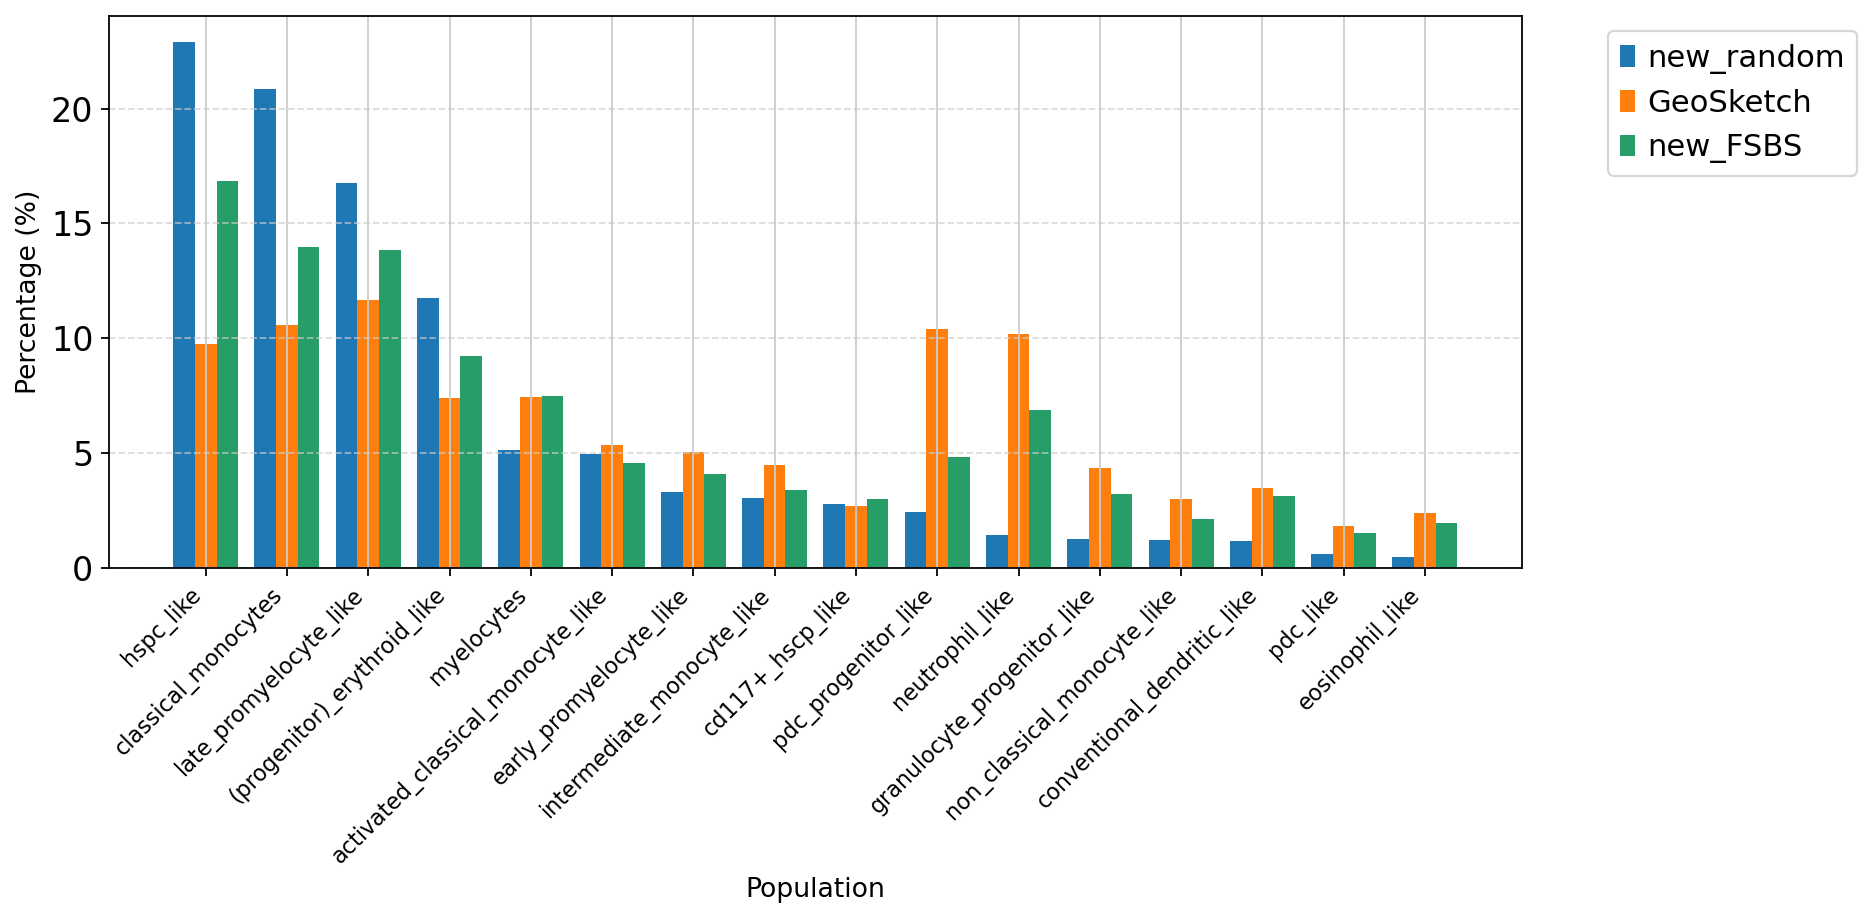

In [27]:

plot_improved_population_distribution([new_random, adata_ref[sketch_index].copy(), new_fsbs],
                                      ['new_random', 'GeoSketch', 'new_FSBS'], adata_ref)

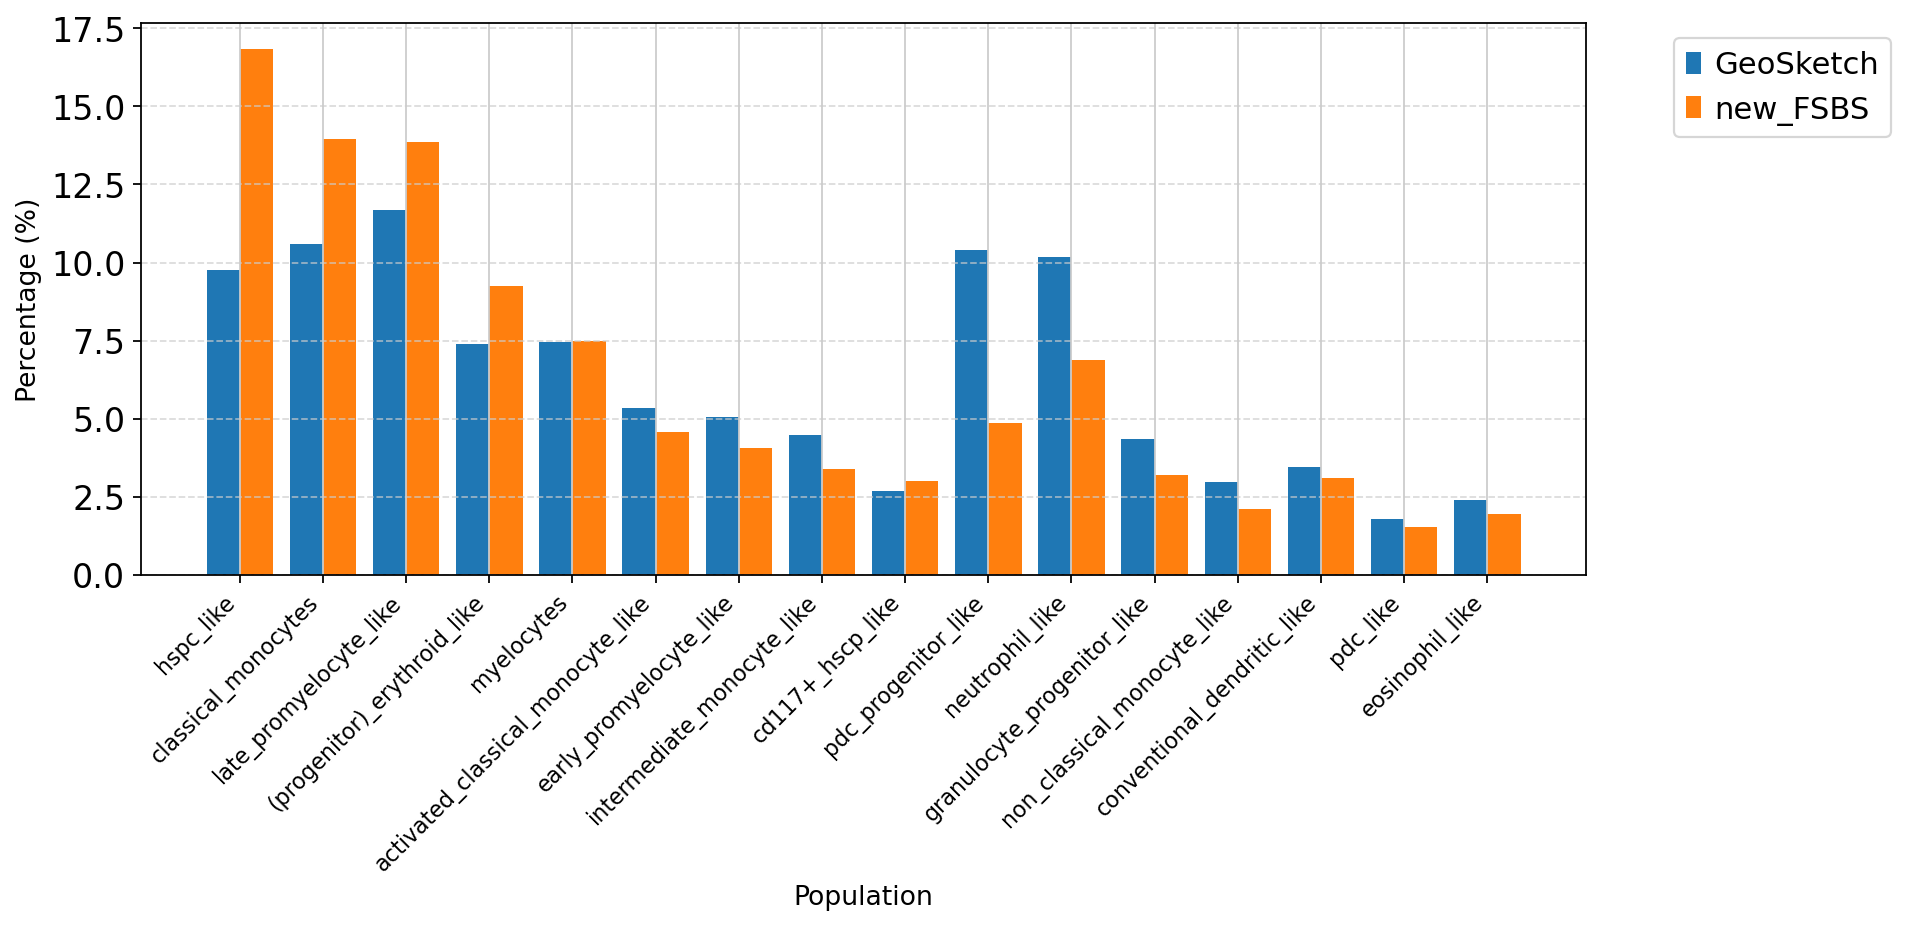

In [28]:

plot_improved_population_distribution([adata_ref[sketch_index].copy(), new_fsbs],
                                      ['GeoSketch', 'new_FSBS'], adata_ref)